In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

Comprobamos el GPU

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num GPUs Available:  0


#Procesamiento de datos
Nuestro dataset ya se encuentra dividido en test, train y validation, por lo que solo es necesario acceder a ellos por medio del path para poder procesarlos.

In [3]:
train_path = 'Pokemon/train'
validation_path = 'Pokemon/valid'
test_path = 'Pokemon/test'

En este caso manejaremos un dataset de tipos de comida, siendo dividido en 5 clases:

*   squirtle
*   charmander
*   bulbasaur
*   mewtwo
*   pikachu


Por lo tanto deberemos manejar un modelo categórico, de manera que podamos clasificar y agrupar los datos que sean introducidos al modelo según sus características.

Se utilizó como base el modelo VGG16 para el entrenamiento del modelo.

In [4]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(200, 200))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    return img

In [7]:
"""
from keras.preprocessing.image import ImageDataGenerator
import os

# Número de imágenes aumentadas por clase que se generarán
num_generated_images = 400

# Crea un objeto ImageDataGenerator con las transformaciones deseadas
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Obtén la lista de subdirectorios/clases
class_names = os.listdir(train_path)

# Itera a través de cada subdirectorio/clase
for class_name in class_names:
    class_dir = os.path.join(train_path, class_name)
    class_images = os.listdir(class_dir)

    # Genera imágenes aumentadas y guárdalas en el mismo directorio de la clase correspondiente
    for image_name in class_images:
        image_path = os.path.join(class_dir, image_name)
        img = load_and_preprocess_image(image_path)
        img = img.reshape((1,) + img.shape)

        i = 0
        for batch in datagen.flow(img, batch_size=1):
            augmented_image = batch[0]
            save_augmented_image(augmented_image, class_dir, image_name, i)
            i += 1
            if i >= num_generated_images:
                break
"""

"\nfrom keras.preprocessing.image import ImageDataGenerator\nimport os\n\n# Número de imágenes aumentadas por clase que se generarán\nnum_generated_images = 400\n\n# Crea un objeto ImageDataGenerator con las transformaciones deseadas\ndatagen = ImageDataGenerator(\n    rescale=1./255,\n    rotation_range=40,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    shear_range=0.2,\n    zoom_range=0.2,\n    horizontal_flip=True,\n    fill_mode='nearest'\n)\n\n# Obtén la lista de subdirectorios/clases\nclass_names = os.listdir(train_path)\n\n# Itera a través de cada subdirectorio/clase\nfor class_name in class_names:\n    class_dir = os.path.join(train_path, class_name)\n    class_images = os.listdir(class_dir)\n\n    # Genera imágenes aumentadas y guárdalas en el mismo directorio de la clase correspondiente\n    for image_name in class_images:\n        image_path = os.path.join(class_dir, image_name)\n        img = load_and_preprocess_image(image_path)\n        img = img.reshape((1

In [6]:
train_datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 40,
							width_shift_range = 0.2,
							height_shift_range = 0.2,
							shear_range = 0.2,
							zoom_range = 0.2,
							horizontal_flip = True,)

train_generator = train_datagen.flow_from_directory(
							train_path,
							target_size = (200, 200),
							batch_size = 20,
							class_mode ='categorical')

val_datagen = ImageDataGenerator(1./255)

val_generator = val_datagen.flow_from_directory(
							validation_path,
							target_size = (200,200),
							batch_size =20,
							class_mode= 'categorical')

test_datagen = ImageDataGenerator(1./255)

test_generator = test_datagen.flow_from_directory(
							test_path,
							target_size = (200, 200),
							batch_size = 20,
							class_mode= 'categorical')

conv_base= VGG16(weights='imagenet',
							include_top = False,
							input_shape = (200,200,3))

Found 1210 images belonging to 5 classes.
Found 182 images belonging to 5 classes.
Found 261 images belonging to 5 classes.


#Primera iteración


##Preparación del modelo


Para la primera iteración se utilizó un modelo secuencial, nuevamente, tomando como base VGG16. Dado que la base ya fue previamente entrenada, el parámetro para que siga aprendiendo será falso.

Una vez que haya terminado se transformarán los datos en un arreglo con una capa de Flatten y se clasificarán por medio de dos capas densas.

In [7]:
model1 = models.Sequential()
model1.add(conv_base)
model1.add(layers.Flatten())
model1.add(layers.Dense(256,activation='relu'))
model1.add(layers.Dense(5,activation='softmax'))

conv_base.trainable = False

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 19,434,821
Trainable params: 4,720,133
Non-trainable params: 14,714,688
_________________________________________________________________


Al compilar el modelo se utilizará el RMSprop como optimizer, con una tasa de aprendizaje de 0.0002.

RMSprop trabaja manteniendo un promedio móvil sobre el cuadrado de los gradientes y dividiendo el gradiente entre la raíz de este promedio.
La pérdida se calculará con un Cross Entropy categórico dado que estamos trabjando con diversas clases.

La medida de aprendizaje será en accurancy.

In [8]:
model1.compile(loss='categorical_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=2e-5),
						metrics=['acc'])

Para el entrenamiento del modelo mantendremos 30 steps por cada época, con un total de 15 épocas.

En cuanto a la validación utilizaremos 25 steps.

In [10]:
history = model1.fit(train_generator,
				steps_per_epoch = 30,
				epochs = 10,
				validation_data = val_generator,
				validation_steps = 25)

Epoch 1/10
30/30 [==============================] - 76s 3s/step - loss: 1.0976 - acc: 0.6400 - val_loss: 19.0477 - val_acc: 0.4341
Epoch 2/10
30/30 [==============================] - 55s 2s/step - loss: 0.9089 - acc: 0.6949
Epoch 3/10
30/30 [==============================] - 57s 2s/step - loss: 0.7586 - acc: 0.7678
Epoch 4/10
30/30 [==============================] - 55s 2s/step - loss: 0.6599 - acc: 0.7797
Epoch 5/10
30/30 [==============================] - 57s 2s/step - loss: 0.5724 - acc: 0.8417
Epoch 6/10
30/30 [==============================] - 57s 2s/step - loss: 0.5185 - acc: 0.8617
Epoch 7/10
30/30 [==============================] - 56s 2s/step - loss: 0.4773 - acc: 0.8576
Epoch 8/10
30/30 [==============================] - 57s 2s/step - loss: 0.4437 - acc: 0.8633
Epoch 9/10
30/30 [==============================] - 57s 2s/step - loss: 0.4381 - acc: 0.8650
Epoch 10/10
30/30 [==============================] - 57s 2s/step - loss: 0.3995 - acc: 0.8917


#Resultados

In [12]:
print(history.history.keys())


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [14]:
epochs = range(1, len(acc) + 1)

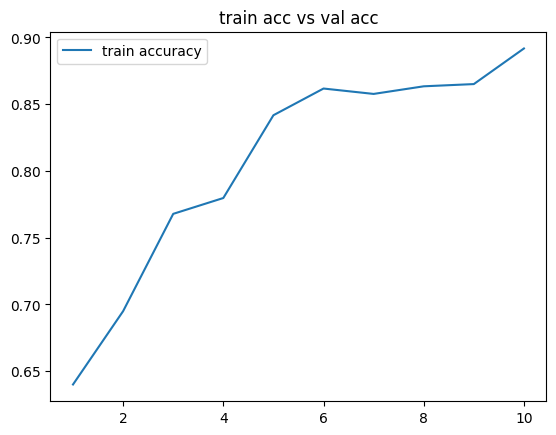

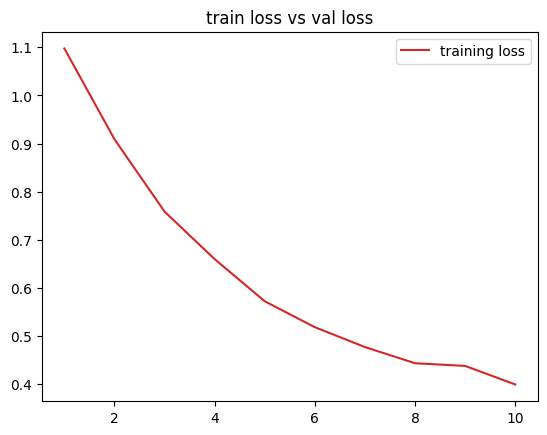

In [15]:
import matplotlib.pyplot as plt

plt.plot(epochs, acc, 'tab:blue', label='train accuracy')
#plt.plot(epochs, val_acc, 'tab:green', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'tab:red', label='training loss')
#plt.plot(epochs, val_loss, 'tab:green', label='validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()


In [16]:
test_loss, test_acc = model1.evaluate(test_generator, steps = 25)
print('\ntest acc :\n', test_acc)

25/25 [==============================] - 27s 1s/step - loss: 21.0298 - acc: 0.5594

test acc :
 0.5593869686126709


#Segunda iteración
##Preparación del modelo
Para la segunda iteración se utilizó la misma base del modelo anterior, pues parecía apuntar a una dirección adecuada, por lo que se optó por ajustar los hiper parámetros.

In [17]:
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256,activation='relu'))
model2.add(layers.Dense(5,activation='softmax'))

conv_base.trainable = False

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               4718848   
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 19,434,821
Trainable params: 4,720,133
Non-trainable params: 14,714,688
_________________________________________________________________


Al compilar el modelo se nuevamente se utilió el RMSprop como optimizer, pero ahora una tasa de aprendizaje de 0.0001.

La pérdida se calculará con un Cross Entropy categórico dado que estamos trabjando con diversas clases.

La medida de aprendizaje será en accurancy.

In [18]:
model2.compile(loss='categorical_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=1e-5),
						metrics=['acc'])

Los parámetros de aprendizaje fueron incrementados para mejorar el rendimiento del modelo.

Se incrementaron a 65 los steps por cada época, con ahora un total de 50 épocas.

En cuanto a la validación utilizaremos 60 steps.

In [19]:
history = model2.fit(train_generator,
				steps_per_epoch = 40,
				epochs = 20,
				validation_data = val_generator,
				validation_steps = 60)

Epoch 1/20
40/40 [==============================] - 112s 3s/step - loss: 1.3983 - acc: 0.4051 - val_loss: 18.3094 - val_acc: 0.2418
Epoch 2/20
40/40 [==============================] - 89s 2s/step - loss: 1.1461 - acc: 0.5886
Epoch 3/20
40/40 [==============================] - 87s 2s/step - loss: 0.9804 - acc: 0.6987
Epoch 4/20
40/40 [==============================] - 86s 2s/step - loss: 0.8507 - acc: 0.7278
Epoch 5/20
40/40 [==============================] - 96s 2s/step - loss: 0.7744 - acc: 0.7850
Epoch 6/20
40/40 [==============================] - 90s 2s/step - loss: 0.6696 - acc: 0.8127
Epoch 7/20
40/40 [==============================] - 92s 2s/step - loss: 0.6320 - acc: 0.8101
Epoch 8/20
40/40 [==============================] - 86s 2s/step - loss: 0.5790 - acc: 0.8400
Epoch 9/20
40/40 [==============================] - 86s 2s/step - loss: 0.5286 - acc: 0.8595
Epoch 10/20
40/40 [==============================] - 82s 2s/step - loss: 0.4791 - acc: 0.8722
Epoch 11/20
40/40 [===========

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [21]:
epochs = range(1, len(acc)+1)

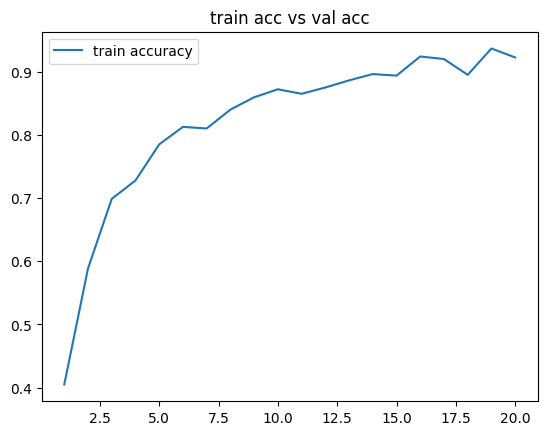

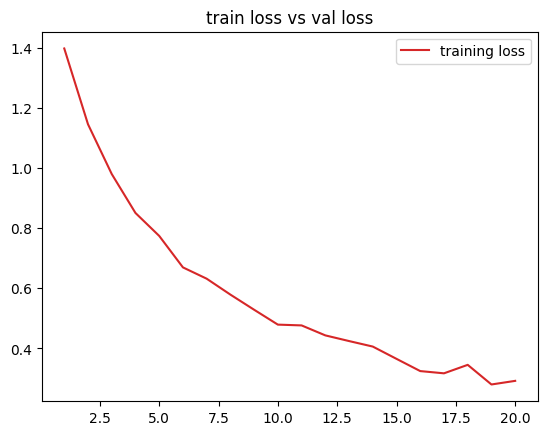

In [23]:
plt.plot(epochs,acc,'tab:blue',label='train accuracy')
#plt.plot(epochs,val_acc, 'tab:green', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'tab:red', label ='training loss')
#plt.plot(epochs,val_loss, 'tab:green', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

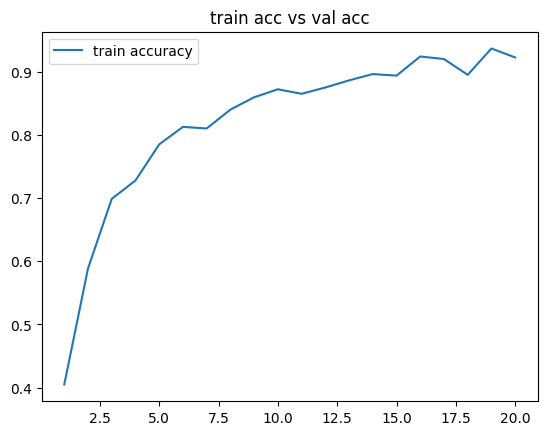

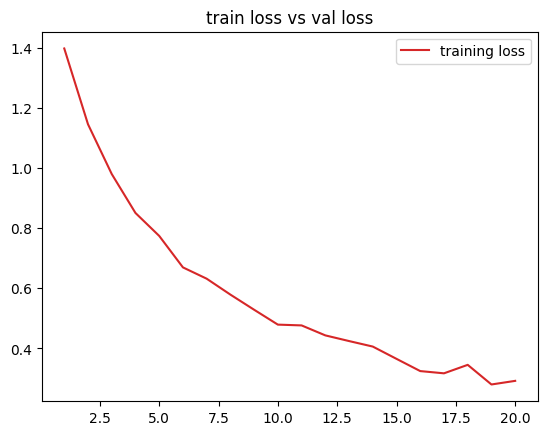

In [25]:
plt.plot(epochs,acc,'tab:blue',label='train accuracy')
#plt.plot(epochs,val_acc, 'tab:green', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'tab:red', label ='training loss')
#plt.plot(epochs,val_loss, 'tab:green', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

In [27]:
test_loss, test_acc = model2.evaluate(test_generator, steps = 50)
print('\ntest acc :\n', test_acc)

50/50 [==============================] - 25s 462ms/step - loss: 18.7876 - acc: 0.6169

test acc :
 0.6168582439422607


In [28]:
model2.save('PokemomLoad.h5')